In [1]:
# %pip install numpy
# %pip install -U scikit-learn imbalanced-learn
# %pip install pillow
# %pip install kagglehub
# %pip install monai
# %pip install matplotlib
# %pip install pylatexenc
# %pip install opencv-python
# %pip install qiskit
# %pip install qiskit_machine_learning
# %pip install pandas
# %pip install seaborn
# %pip install tensorflow
# %pip install imblearn
# %pip install ipywidgets

In [3]:
!unset CUDA_VISIBLE_DEVICES

In [16]:
import os
import pickle
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from monai.transforms import ScaleIntensity
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kagglehub
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils.validation import check_array
from qiskit_machine_learning.algorithms import QSVC
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

import warnings
warnings.filterwarnings('ignore')

#### Download latest version https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [5]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
# print("Path to dataset files:", path)

#### Define dataset paths

In [6]:
train_path_norm = f'{path}/chest_xray/chest_xray/train/NORMAL'
train_path_pneu = f'{path}/chest_xray/chest_xray/train/PNEUMONIA'
test_path_norm = f'{path}/chest_xray/chest_xray/test/NORMAL'
test_path_pneu = f'{path}/chest_xray/chest_xray/test/PNEUMONIA'

#### Count files in directory

In [7]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.endswith(('.jpg', '.png', '.jpeg'))])

print("Length train_path_norm:", count_images(train_path_norm))
print("Length train_path_pneu:", count_images(train_path_pneu))
print("Length test_path_norm:", count_images(test_path_norm))
print("Length test_path_pneu:", count_images(test_path_pneu))

Length train_path_norm: 1341
Length train_path_pneu: 3875
Length test_path_norm: 234
Length test_path_pneu: 390


#### Check data

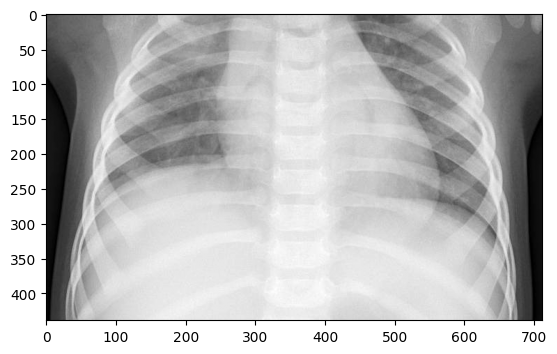

In [8]:
xray_image = cv2.imread(f'{train_path_pneu}/person1_bacteria_1.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(xray_image, cmap='gray')

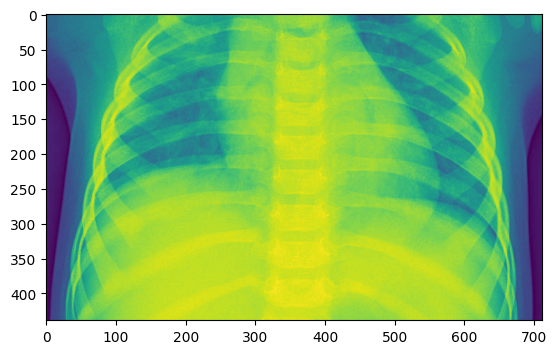

In [9]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
xray_image_scaled = transform_img(xray_image)
colored_xray = cm.viridis(xray_image_scaled)
plt.imshow(colored_xray)

#### Load and preprocess the images

In [10]:
img_size = (224, 224)

def load_images_from_folder(folder, label, target_size=img_size):
    """
    Loads images from a given folder and resizes them to the specified target size.
    Converts images to RGB and flattens them into numpy arrays.

    Args:
        folder (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of image data and their corresponding labels.
    """
    data, labels = [], []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("RGB").resize(target_size)
            data.append(np.array(img).flatten())
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    return data, labels

def load_and_limit_data(path, label, num_samples, target_size=(256, 256)):
    """
    Loads and limits the number of images from a folder to a specified number of samples.
    Ensures images are resized to the specified target size.

    Args:
        path (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        num_samples (int): Maximum number of samples to load.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of limited image data and their corresponding labels.
    """
    data, labels = load_images_from_folder(path, label, target_size)
    indices = np.random.choice(len(data), min(num_samples, len(data)), replace=False)
    data = [data[i] for i in indices]
    labels = [labels[i] for i in indices]
    return data, labels

#### Display images for train

Found 5216 validated image filenames belonging to 2 classes.


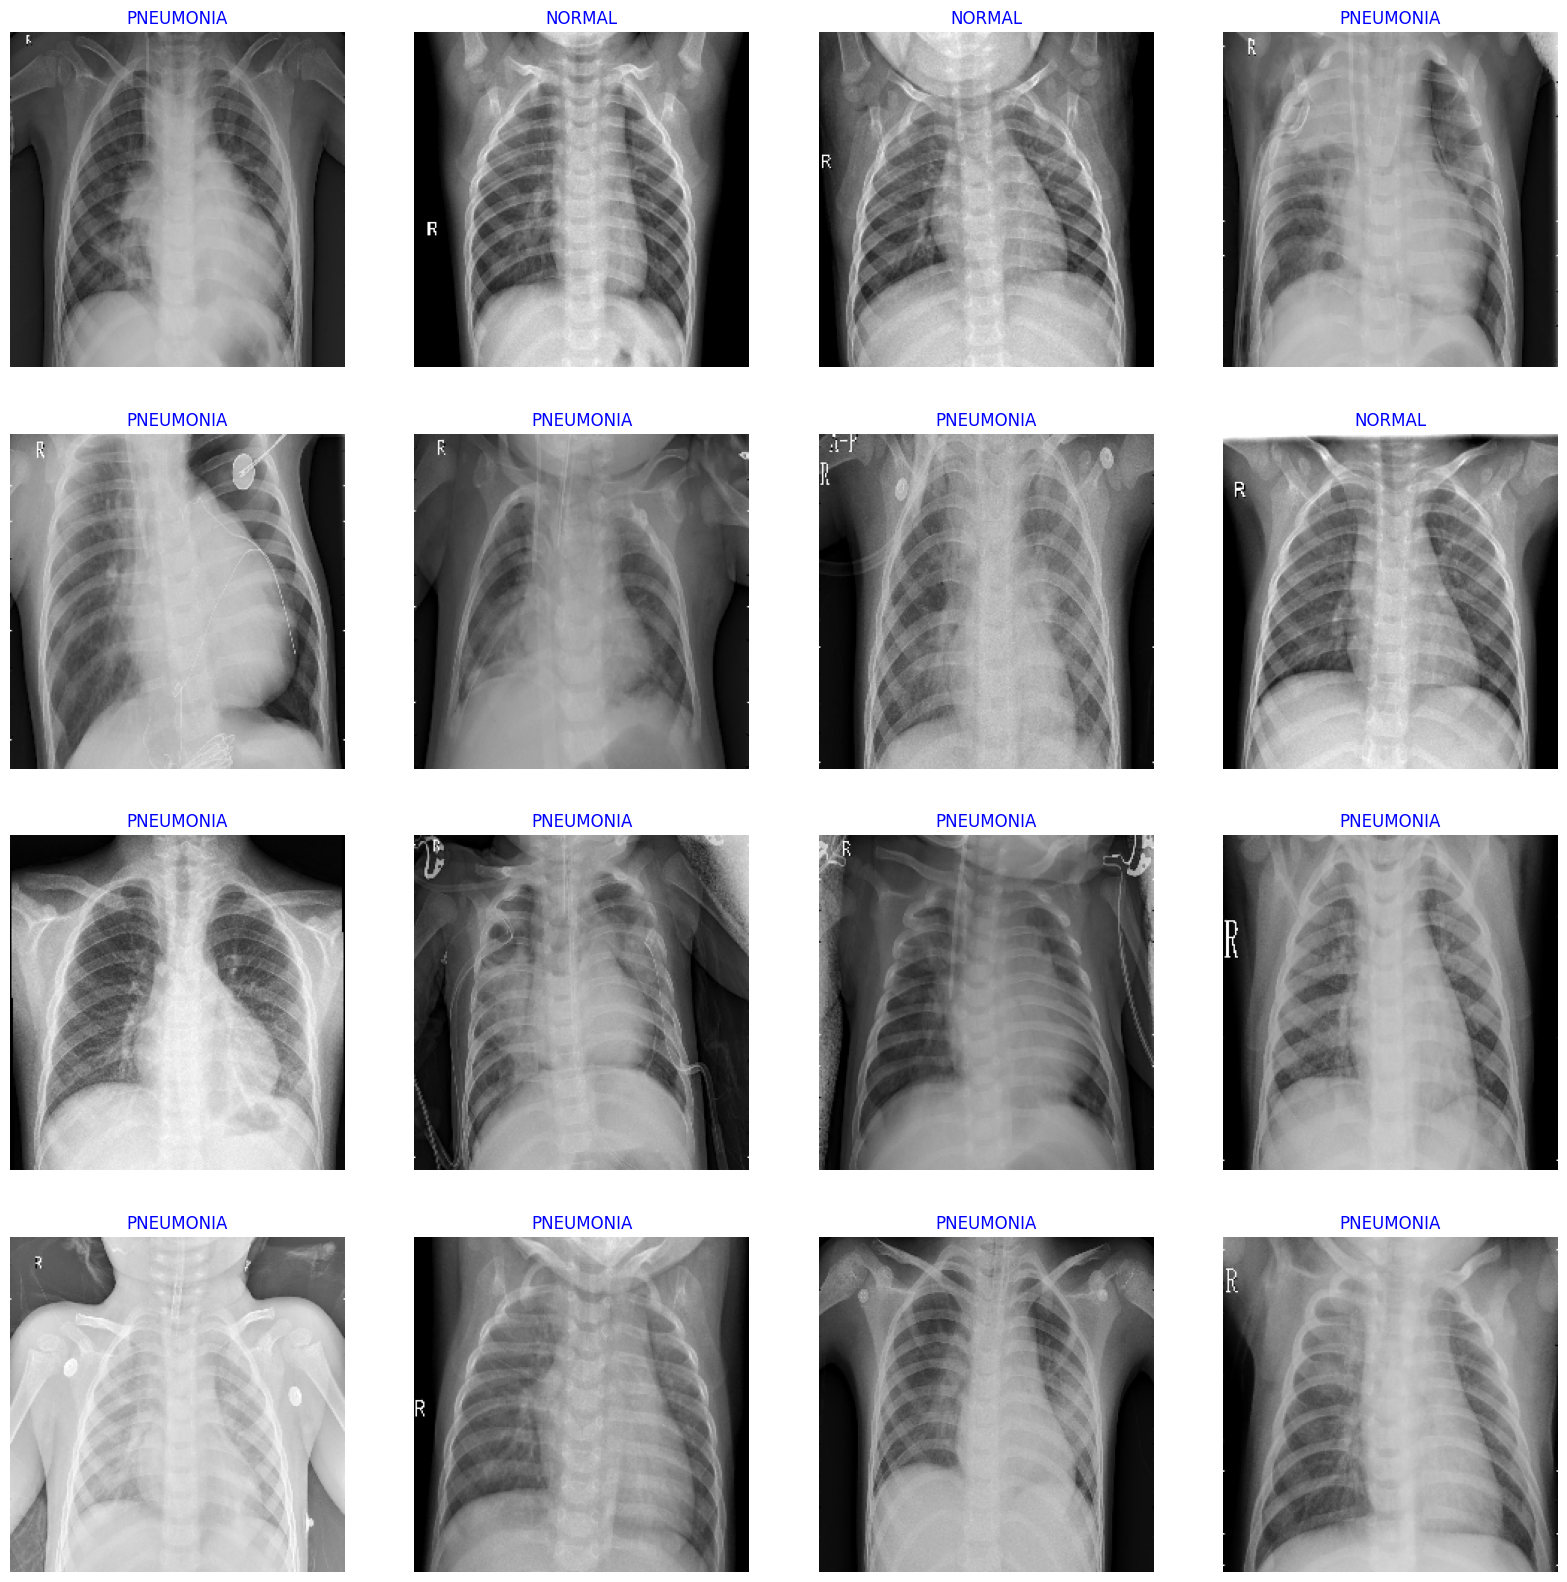

In [11]:
def create_dataframe_from_directory(directory, label):
    filepaths = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    labels = [label] * len(filepaths)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

df_norm = create_dataframe_from_directory(train_path_norm, 'NORMAL')
df_pneu = create_dataframe_from_directory(train_path_pneu, 'PNEUMONIA')

train_df = pd.concat([df_norm, df_pneu], ignore_index=True)

train_df = train_df.sample(frac=1).reset_index(drop=True)

def scalar(img):
    return img

batch_size = 32
tr_gen = ImageDataGenerator(preprocessing_function= scalar)


train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col= 'filepaths',
    y_col= 'labels',
    target_size= img_size,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= True,
    batch_size= batch_size
)

g_dict = train_gen.class_indices     
classes = list(g_dict.keys())       
images, labels = next(train_gen)      
plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255     
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

#### Proportional sampling for balanced dataset

In [17]:
num_samples = 400
num_samples_test = 80

norm_ratio = 1341 / (1341 + 3875)
pneu_ratio = 3875 / (1341 + 3875)

num_samples_norm = int(num_samples * norm_ratio)
num_samples_pneu = int(num_samples * pneu_ratio)

num_samples_norm_test = int(num_samples_test * norm_ratio)
num_samples_pneu_test = int(num_samples_test * pneu_ratio)

In [13]:
train_data_norm, train_labels_norm = load_and_limit_data(train_path_norm, 0, num_samples_norm, target_size=img_size)
train_data_pneu, train_labels_pneu = load_and_limit_data(train_path_pneu, 1, num_samples_pneu, target_size=img_size)
X_train = np.array(train_data_norm + train_data_pneu)
y_train = np.array(train_labels_norm + train_labels_pneu)

test_data_norm, test_labels_norm = load_and_limit_data(test_path_norm, 0, num_samples_norm_test, target_size=img_size)
test_data_pneu, test_labels_pneu = load_and_limit_data(test_path_pneu, 1, num_samples_pneu_test, target_size=img_size)
X_test = np.asarray(test_data_norm + test_data_pneu)
y_test = np.asarray(test_labels_norm + test_labels_pneu)

In [18]:
scaler = MinMaxScaler(feature_range=(0, np.pi))
X_scaled = scaler.fit_transform(X_train)  # Scale training data

X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled = train_test_split(
    X_scaled, y_train, train_size=0.8, shuffle=True
)

pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test)

smote = SMOTE(sampling_strategy="auto")
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train_scaled)

X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)

X_val_tensor = torch.tensor(X_val_pca, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

#### Data

In [12]:
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train)
X_train_pca_validated = check_array(X_train_pca, accept_sparse=True)

smote = SMOTE(sampling_strategy="auto")
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca_validated, y_train)

X_test_pca = pca.transform(X_test)

X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

#### Display the categorized file paths and labels

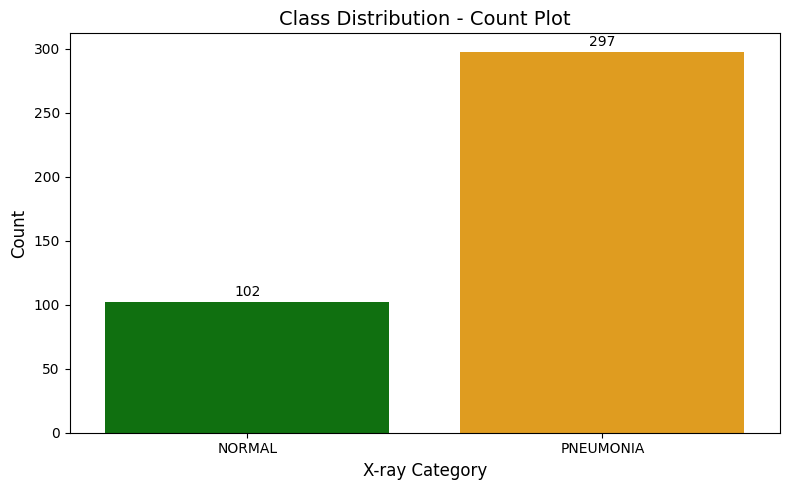

In [19]:
labels = train_labels_norm + train_labels_pneu

df = pd.DataFrame({'label': ['NORMAL' if lbl == 0 else 'PNEUMONIA' for lbl in labels]})

plt.figure(figsize=(8, 5))
ax = sns.countplot(
    data=df, 
    x='label', 
    hue='label',
    palette={'NORMAL': 'green', 'PNEUMONIA': 'orange'},
    dodge=False,
    legend=False
)

plt.title('Class Distribution - Count Plot', fontsize=14)
plt.xlabel('X-ray Category', fontsize=12)
plt.ylabel('Count', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 7.5), textcoords='offset points')

plt.tight_layout()
plt.show()

#### Plot the data

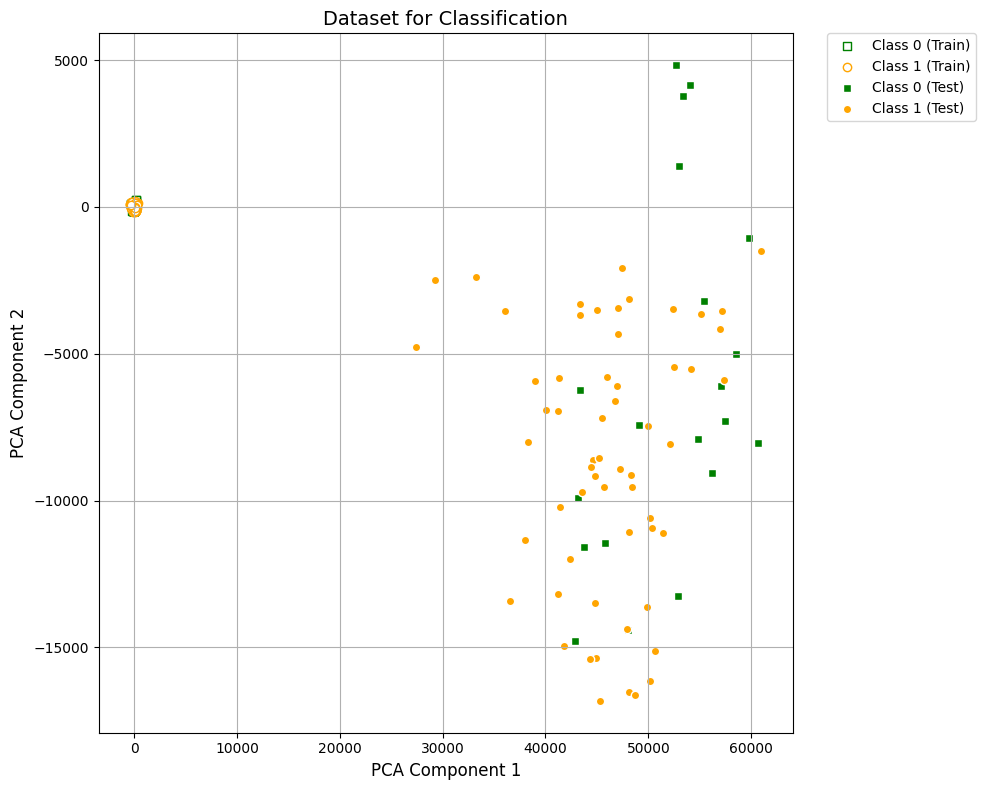

In [20]:
plt.figure(figsize=(10, 8))

plt.scatter(
    X_train_tensor[np.where(y_train_tensor == 0)[0], 0].numpy(),
    X_train_tensor[np.where(y_train_tensor == 0)[0], 1].numpy(),
    marker="s",
    facecolors="w",
    edgecolors="green",
    label="Class 0 (Train)",
)

plt.scatter(
    X_train_tensor[np.where(y_train_tensor == 1)[0], 0].numpy(),
    X_train_tensor[np.where(y_train_tensor == 1)[0], 1].numpy(),
    marker="o",
    facecolors="w",
    edgecolors="orange",
    label="Class 1 (Train)",
)

plt.scatter(
    X_test_pca[np.where(y_test == 0)[0], 0],
    X_test_pca[np.where(y_test == 0)[0], 1],
    marker="s",
    facecolors="green",
    edgecolors="w",
    label="Class 0 (Test)",
)

plt.scatter(
    X_test_pca[np.where(y_test == 1)[0], 0],
    X_test_pca[np.where(y_test == 1)[0], 1],
    marker="o",
    facecolors="orange",
    edgecolors="w",
    label="Class 1 (Test)",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Dataset for Classification", fontsize=14)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Set up quantum kernel

In [21]:
feature_map = ZZFeatureMap (feature_dimension=4, reps=2, entanglement="linear")
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

#### Fit the model

In [23]:
svc_callable = SVC(kernel=kernel.evaluate)

svc_callable.fit(X_train_resampled, y_train_resampled)

score_callable_function = svc_callable.score(X_test_pca, y_test)

print(f"Callable kernel classification test score: {score_callable_function}")

KeyboardInterrupt: 

In [18]:
matrix_train = kernel.evaluate(x_vec=X_train_resampled)
matrix_test = kernel.evaluate(x_vec=X_test_pca, y_vec=X_train_resampled)

#### Save kernels to a file

In [19]:
with open('kernels/FidelityQuantumKernel_matrix_train.pkl', 'wb') as f:
    pickle.dump(matrix_train, f)

with open('kernels/FidelityQuantumKernel_matrix_test.pkl', 'wb') as f:
    pickle.dump(matrix_test, f)

#### Load the kernel from the file

In [19]:
with open('kernels/FidelityQuantumKernel_matrix_train.pkl', 'rb') as f:
    loaded_kernel_matrix_train = pickle.load(f)

with open('kernels/FidelityQuantumKernel_matrix_test.pkl', 'rb') as f:
    loaded_kernel_matrix_test = pickle.load(f)

#### Adjustment SVC to use class weights for imbalance handling

In [20]:
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [21]:
svc_precomputed = SVC(kernel="precomputed", class_weight=class_weights_dict)

svc_precomputed.fit(matrix_train, y_train_resampled)

score_precomputed_kernel = svc_precomputed.score(matrix_test, y_test)

print(f"Precomputed kernel classification test score: {score_precomputed_kernel}")

Precomputed kernel classification test score: 0.25316455696202533


In [22]:
qsvc = QSVC(quantum_kernel=kernel)

qsvc.fit(X_train_resampled, y_train_resampled)

qsvc_score = qsvc.score(X_test_pca, y_test)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 0.5316455696202531


#### Save model

In [23]:
qsvc.save('models/QSVC_Fidelity_quantm_trainer_brain_tumor.model')

#### Load model

In [24]:
loaded_model = QSVC.load('models/QSVC_Fidelity_quantm_trainer_brain_tumor.model')

#### Evaluate Results

In [24]:
y_pred_callable = svc_callable.predict(X_test_pca)
y_pred_precomputed = svc_precomputed.predict(matrix_test)
y_pred_qsvc = qsvc.predict(X_test_pca)

print("\nCallable Kernel Classification Report:")
print(metrics.classification_report(y_test, y_pred_callable))
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred_callable))

print("\nPrecomputed Kernel Classification Report:")
print(metrics.classification_report(y_test, y_pred_precomputed))
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred_precomputed))

print("\nQSVC Classification Report:")
print(metrics.classification_report(y_test, y_pred_qsvc))
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred_qsvc))


Callable Kernel Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.50      0.33        20
           1       0.74      0.47      0.58        59

    accuracy                           0.48        79
   macro avg       0.49      0.49      0.45        79
weighted avg       0.61      0.48      0.51        79

Confusion Matrix:
[[10 10]
 [31 28]]

Precomputed Kernel Classification Report:
              precision    recall  f1-score   support

           0       0.25      1.00      0.40        20
           1       0.00      0.00      0.00        59

    accuracy                           0.25        79
   macro avg       0.13      0.50      0.20        79
weighted avg       0.06      0.25      0.10        79

Confusion Matrix:
[[20  0]
 [59  0]]

QSVC Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.50      0.36        20
           1       0.77      0.56      0.65        


Callable Kernel Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.50      0.33        20
           1       0.74      0.47      0.58        59

    accuracy                           0.48        79
   macro avg       0.49      0.49      0.45        79
weighted avg       0.61      0.48      0.51        79

Confusion Matrix:
[[10 10]
 [31 28]]

Precomputed Kernel Classification Report:
              precision    recall  f1-score   support

           0       0.25      1.00      0.40        20
           1       0.00      0.00      0.00        59

    accuracy                           0.25        79
   macro avg       0.13      0.50      0.20        79
weighted avg       0.06      0.25      0.10        79

Confusion Matrix:
[[20  0]
 [59  0]]

QSVC Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.50      0.36        20
           1       0.77      0.56      0.65        59

    accuracy                           0.54        79
   macro avg       0.52      0.53      0.50        79
weighted avg       0.64      0.54      0.57        79

Confusion Matrix:
[[10 10]
 [26 33]]


#### Compute ROC AUC Scores

In [25]:
roc_auc_callable = metrics.roc_auc_score(y_test, svc_callable.decision_function(X_test_pca))
roc_auc_precomputed = metrics.roc_auc_score(y_test, svc_precomputed.decision_function(matrix_test))
roc_auc_qsvc = metrics.roc_auc_score(y_test, qsvc.decision_function(X_test_pca))

print(f"\nROC AUC Callable Kernel: {roc_auc_callable}")
print(f"ROC AUC Precomputed Kernel: {roc_auc_precomputed}")
print(f"ROC AUC QSVC: {roc_auc_qsvc}")


ROC AUC Callable Kernel: 0.5313559322033898
ROC AUC Precomputed Kernel: 0.514406779661017
ROC AUC QSVC: 0.4805084745762712


#### Predicted probability for Positive Class for QSVC

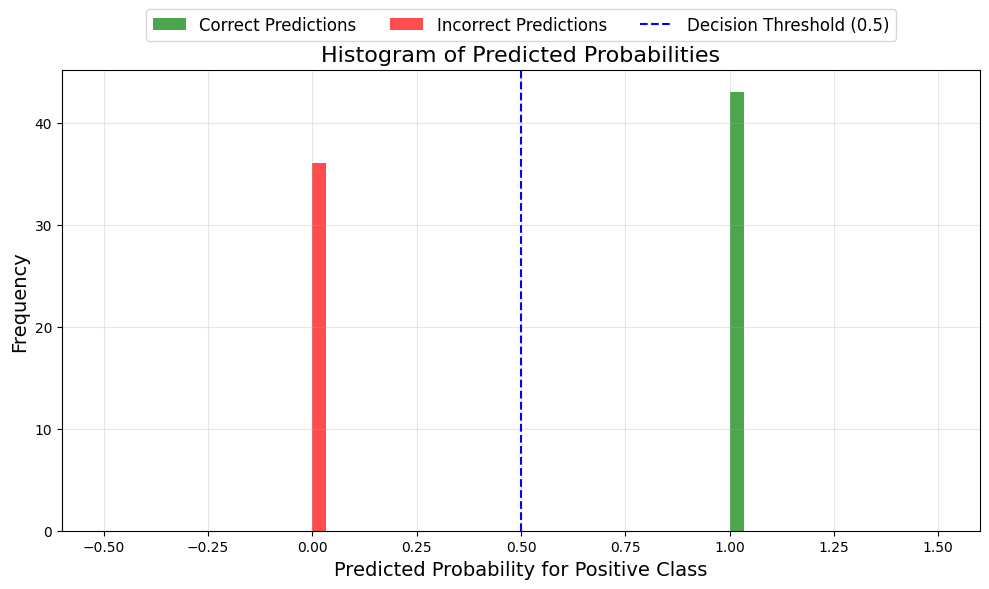

In [28]:
if isinstance(y_pred_qsvc, np.ndarray):
    y_pred_qsvc = torch.tensor(y_pred_qsvc, dtype=torch.float32)

predictions = torch.round(y_pred_qsvc)
correct_predictions = (predictions == 1)
incorrect_predictions = ~correct_predictions

correct_probs = y_pred_qsvc[correct_predictions]
incorrect_probs = y_pred_qsvc[incorrect_predictions]

plt.figure(figsize=(10, 6))

plt.hist(
    correct_probs.numpy(), 
    bins=30, 
    alpha=0.7, 
    color='green', 
    label='Correct Predictions'
)

plt.hist(
    incorrect_probs.numpy(), 
    bins=30, 
    alpha=0.7, 
    color='red', 
    label='Incorrect Predictions'
)

plt.axvline(0.5, color='blue', linestyle='--', label='Decision Threshold (0.5)', linewidth=1.5)

plt.title('Histogram of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability for Positive Class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### PCA of model prediction for QSVC

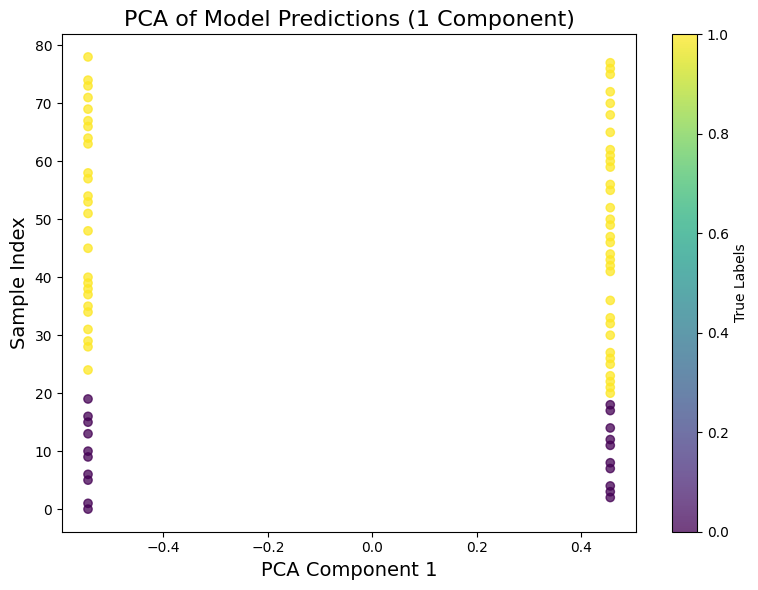

In [29]:
if y_pred_qsvc.ndim == 1:
    labels_test_reshaped = y_pred_qsvc.reshape(-1, 1)

pca = PCA(n_components=1)
features_pca = pca.fit_transform(labels_test_reshaped)

plt.figure(figsize=(8, 6))

plt.scatter(features_pca, range(len(features_pca)), c=y_test, cmap='viridis', alpha=0.75)

# Add color bar and labels
plt.colorbar(label='True Labels')
plt.title('PCA of Model Predictions (1 Component)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('Sample Index', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

#### Plot the confusion matrix

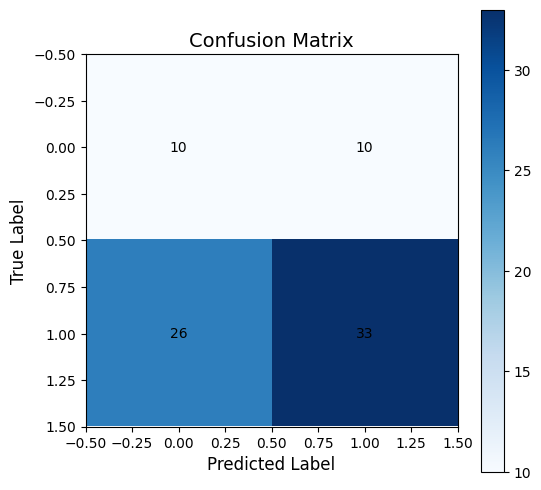

In [30]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred_qsvc)
plt.figure(figsize=(6, 6))
plt.title("Confusion Matrix", fontsize=14)
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues, aspect='equal')
plt.colorbar()

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f"{conf_matrix[i, j]}", ha="center", va="center", color="black", fontsize=10)

plt.show()

#### Plot the ROC curve

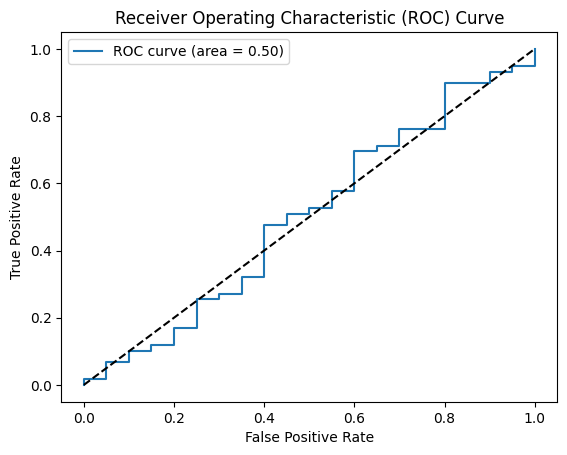

In [31]:
decision_function = qsvc.decision_function(X_test_pca)

fpr, tpr, _ = metrics.roc_curve(y_test, decision_function)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="best")

plt.show()

In [32]:
import utils.tutorial_magics

%qiskit_version_table
%qiskit_copyright